# Using EchoClassesDataset()

Miguel Xochicale [@mxochicale](https://github.com/mxochicale)  
Jan2022


## 1.1 Introduction
This notebook presents prototypes to pre-process echocardiography datasets with the use of pytorch features. 

## 1.2 Running notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
## 1.3 References
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 




## 2. Jupyter Notebook

### 2.1 Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from torch.utils.data import DataLoader
from torchvision import transforms, utils

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset

HOME_PATH = os.path.expanduser(f'~')
CONFIG_FILES_PATH= 'repositories/echocardiography/scripts/config_files'
YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, 'config_echo_classes.yml')

with open(YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

### 2.2 Setting variables and loading datasets using pytorch dataloader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define some static transforms, i.e. transforms that apply to the entire dataset.
# These transforms are not augmentation.
pretransform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=config['pretransform_im_size']),
    transforms.ToTensor(),  # this normalizes in
]
)

dataset = EchoClassesDataset(main_data_path=config['main_data_path'],
                             participant_videos_list=config['participant_videos_list'],
                             participant_path_json_list=config['participant_path_json_list'],
                             crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
                             clip_duration_nframes=config['n_frames'],
                             device=device,
                             max_background_duration_in_secs=config['max_background_duration_in_secs'],
                             pretransform=pretransform,
                             use_tmp_storage=True,
                             )


### 2.3 Using dataloader with pre-processing image techniques

Number of clips: 16
Display the two clips:


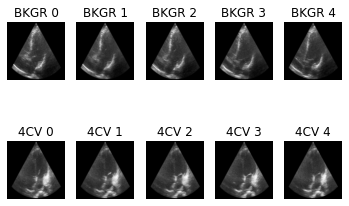

In [3]:
print(f'Number of clips: {len(dataset)}')
clip_index_a = 0  # this must be within the dataset length
clip_index_b = 15  # this must be within the dataset length
data_a = dataset[clip_index_a]
data_b = dataset[clip_index_b]

print('Display the two clips:')
labelnames = ('BKGR', '4CV')
plt.figure()
for f in range(data_a[0].shape[1]):
    plt.subplot(2, data_a[0].shape[1], f+1)
    plt.imshow(data_a[0][0, f, ...].cpu().data.numpy(), cmap='gray')
    plt.axis('off')
    plt.title('{} {}'.format(labelnames[data_a[1]], f))
for f in range(data_b[0].shape[1]):
    plt.subplot(2, data_b[0].shape[1], f+data_b[0].shape[1]+1)
    plt.imshow(data_b[0][0, f, ...].cpu().data.numpy(), cmap='gray')
    plt.axis('off')
    plt.title('{} {}'.format(labelnames[data_b[1]], f))
plt.show()

